In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

# from IPython.core.interactiveshell import InteractiveShell


In [2]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0-beta0
Eager execution: True


In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = keras.utils.get_file(fname=os.path.basename(train_dataset_url), 
                                        origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))


Local copy of the dataset file: /Users/JQC/.keras/datasets/iris_training.csv


In [5]:
train_dataset_fp

'/Users/JQC/.keras/datasets/iris_training.csv'

In [6]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
df = pd.read_csv(train_dataset_fp, header=None, names=column_names, skiprows=1)

feature_names = column_names[:-1]
label_name = column_names[-1]
df.shape
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [7]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
[*zip(class_names, [0, 1, 2])]

[('Iris setosa', 0), ('Iris versicolor', 1), ('Iris virginica', 2)]

In [8]:
batch_size = 32
train_dataset = tf.data.experimental.make_csv_dataset(train_dataset_fp, 
                                                      batch_size=batch_size, 
                                                      column_names=column_names,
                                                      label_name=label_name,
                                                      num_epochs=1
                                                     )

W0822 19:34:46.739846 4800112064 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [9]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
array([5.6, 5.7, 4.6, 7.2, 6.2, 5.1, 7.7, 6.3, 4.9, 4.9, 5.8, 5. , 5.6,
       4.8, 7.7, 5.7, 4.6, 6.3, 6.3, 5.4, 6. , 6.8, 7.6, 5.4, 5.4, 6.8,
       5. , 7.4, 6.4, 6.4, 4.9, 5. ], dtype=float32)>), ('sepal_width', <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
array([2.5, 4.4, 3.6, 3. , 2.2, 3.8, 3.8, 3.3, 2.4, 3.1, 2.7, 3.5, 2.7,
       3. , 2.8, 2.8, 3.4, 3.3, 2.3, 3.9, 2.9, 3.2, 3. , 3. , 3.9, 3. ,
       3.3, 2.8, 3.2, 3.1, 3.1, 3.4], dtype=float32)>), ('petal_length', <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
array([3.9, 1.5, 1. , 5.8, 4.5, 1.5, 6.7, 6. , 3.3, 1.5, 5.1, 1.6, 4.2,
       1.4, 6.7, 4.1, 1.4, 4.7, 4.4, 1.3, 4.5, 5.9, 6.6, 4.5, 1.7, 5.5,
       1.4, 6.1, 4.5, 5.5, 1.5, 1.6], dtype=float32)>), ('petal_width', <tf.Tensor: id=64, shape=(32,), dtype=float32, numpy=
array([1.1, 0.4, 0.2, 1.6, 1.5, 0.3, 2.2, 2.5, 1. , 0.1, 1.9, 0.6, 1.3,
       0.1, 2. , 1.3, 0.3, 1.6, 1

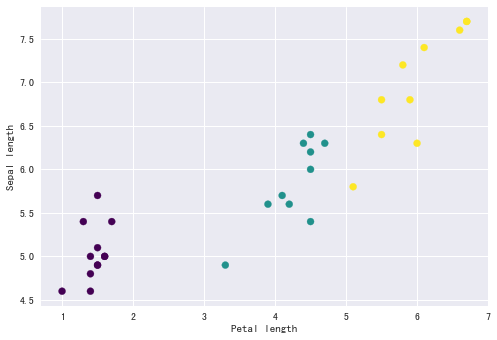

In [10]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [11]:
def pack_features_vector(features, labels):
  """将特征打包到一个数组中"""
  # 这是跟pandas 中df.values很像 是把所有的特征 
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [12]:
# 这是一个批次的 一个批次32个
pack_features_vector(features, labels)

(<tf.Tensor: id=100, shape=(32, 4), dtype=float32, numpy=
 array([[5.6, 2.5, 3.9, 1.1],
        [5.7, 4.4, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [7.2, 3. , 5.8, 1.6],
        [6.2, 2.2, 4.5, 1.5],
        [5.1, 3.8, 1.5, 0.3],
        [7.7, 3.8, 6.7, 2.2],
        [6.3, 3.3, 6. , 2.5],
        [4.9, 2.4, 3.3, 1. ],
        [4.9, 3.1, 1.5, 0.1],
        [5.8, 2.7, 5.1, 1.9],
        [5. , 3.5, 1.6, 0.6],
        [5.6, 2.7, 4.2, 1.3],
        [4.8, 3. , 1.4, 0.1],
        [7.7, 2.8, 6.7, 2. ],
        [5.7, 2.8, 4.1, 1.3],
        [4.6, 3.4, 1.4, 0.3],
        [6.3, 3.3, 4.7, 1.6],
        [6.3, 2.3, 4.4, 1.3],
        [5.4, 3.9, 1.3, 0.4],
        [6. , 2.9, 4.5, 1.5],
        [6.8, 3.2, 5.9, 2.3],
        [7.6, 3. , 6.6, 2.1],
        [5.4, 3. , 4.5, 1.5],
        [5.4, 3.9, 1.7, 0.4],
        [6.8, 3. , 5.5, 2.1],
        [5. , 3.3, 1.4, 0.2],
        [7.4, 2.8, 6.1, 1.9],
        [6.4, 3.2, 4.5, 1.5],
        [6.4, 3.1, 5.5, 1.8],
        [4.9, 3.1, 1.5, 0.1],
        [5. 

In [13]:
df.values

array([[6.4, 2.8, 5.6, 2.2, 2. ],
       [5. , 2.3, 3.3, 1. , 1. ],
       [4.9, 2.5, 4.5, 1.7, 2. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [4.4, 3.2, 1.3, 0.2, 0. ],
       [5.4, 3.4, 1.5, 0.4, 0. ],
       [6.9, 3.1, 5.1, 2.3, 2. ],
       [6.7, 3.1, 4.4, 1.4, 1. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [5.2, 2.7, 3.9, 1.4, 1. ],
       [6.9, 3.1, 4.9, 1.5, 1. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [7.7, 3.8, 6.7, 2.2, 2. ],
       [6.3, 3.3, 4.7, 1.6, 1. ],
       [6.8, 3.2, 5.9, 2.3, 2. ],
       [7.6, 3. , 6.6, 2.1, 2. ],
       [6.4, 3.2, 5.3, 2.3, 2. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [6.7, 3.3, 5.7, 2.1, 2. ],
       [6.4, 2.8, 5.6, 2.1, 2. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [6.1, 2.6, 5.6, 1.4, 2. ],
       [7.2, 3. , 5.8, 1.6, 2. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.8, 2.6, 4. , 1.2, 1. ],
       [5.9, 3. , 5.1, 1.8, 2. ],
       [5.4, 3. , 4.5, 1.5, 1. ],
       [6.7, 3

In [14]:
# 将train_dataset所有的数据映射成数组形式
# Dataset 的特征元素被构成了形如 (batch_size, num_features) 的数组
train_dataset = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset))
print(features)

tf.Tensor(
[[5.6 2.5 3.9 1.1]
 [5.7 4.4 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [7.2 3.  5.8 1.6]
 [6.2 2.2 4.5 1.5]
 [5.1 3.8 1.5 0.3]
 [7.7 3.8 6.7 2.2]
 [6.3 3.3 6.  2.5]
 [4.9 2.4 3.3 1. ]
 [4.9 3.1 1.5 0.1]
 [5.8 2.7 5.1 1.9]
 [5.  3.5 1.6 0.6]
 [5.6 2.7 4.2 1.3]
 [4.8 3.  1.4 0.1]
 [7.7 2.8 6.7 2. ]
 [5.7 2.8 4.1 1.3]
 [4.6 3.4 1.4 0.3]
 [6.3 3.3 4.7 1.6]
 [6.3 2.3 4.4 1.3]
 [5.4 3.9 1.3 0.4]
 [6.  2.9 4.5 1.5]
 [6.8 3.2 5.9 2.3]
 [7.6 3.  6.6 2.1]
 [5.4 3.  4.5 1.5]
 [5.4 3.9 1.7 0.4]
 [6.8 3.  5.5 2.1]
 [5.  3.3 1.4 0.2]
 [7.4 2.8 6.1 1.9]
 [6.4 3.2 4.5 1.5]
 [6.4 3.1 5.5 1.8]
 [4.9 3.1 1.5 0.1]
 [5.  3.4 1.6 0.4]], shape=(32, 4), dtype=float32)


In [15]:
# 建立模型
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4, )), # 输入层
    keras.layers.Dense(10, activation='relu'), # 隐藏层 10个神经元
    keras.layers.Dense(3, activation='softmax') # 因为有3个标签,所以是3
])

In [16]:
# 计算损失
loss_obj = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  y_ = model(x)

  return loss_obj(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.1828827857971191


In [17]:
# 定义梯度
def grad(model, input_, target):
    with tf.GradientTape() as t:
        curr_loss = loss(model=model, x=input_, y=target)
    # 这个球梯度的方法略吊 管你几个因变量 我对模型的训练可变参数球偏导
    return curr_loss, t.gradient(curr_loss, model.trainable_variables)

In [18]:
# 算法的优化器 从下面的数据可以看出 通过优化器的损失更小
optimizer = keras.optimizers.Adam(0.01)

In [19]:
# 未经优化器的
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))
# 经过优化器优化后的 
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.1828827857971191
Step: 1,         Loss: 1.171100378036499


In [20]:
# 保留结果用于绘制
train_loss_results = []
train_accuracy_results = []

num_epochs = 201
for i in range(num_epochs):
    epoch_loss_avg = keras.metrics.Mean()
    epoch_accuracy = keras.metrics.SparseCategoricalAccuracy()
    # train_dataset 是一系列批次的数据 每个批次32个
    for x, y in train_dataset:
        # 优化模型
        loss_value, grads = grad(model, x, y)
        # 更新梯度
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # 追踪进度h当前批次下的损失值
        epoch_loss_avg(loss_value)
        epoch_accuracy(y, model(x))
        
    # 一个循环结束 记录一下损失值和准确率
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    if i % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(i,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
        

Epoch 000: Loss: 1.150, Accuracy: 30.000%
Epoch 050: Loss: 0.580, Accuracy: 98.333%
Epoch 100: Loss: 0.572, Accuracy: 99.167%
Epoch 150: Loss: 0.569, Accuracy: 99.167%
Epoch 200: Loss: 0.568, Accuracy: 99.167%


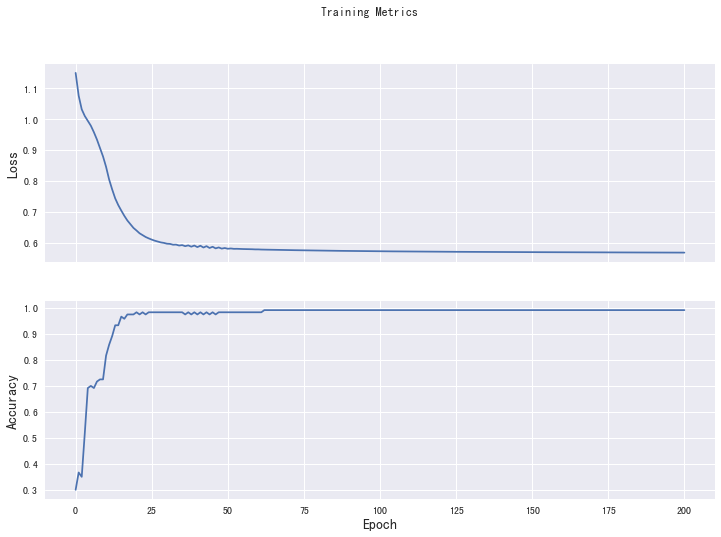

In [25]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel('Loss', fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].plot(train_accuracy_results)

In [27]:
# 加载测试集
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.experimental.make_csv_dataset(test_fp, 
                                                     batch_size=batch_size,
                                                     column_names=column_names, 
                                                     label_name='species', 
                                                     num_epochs=1, 
                                                     shuffle=False)
# 将数据打包成多组数据,没组32个
test_dataset = test_dataset.map(pack_features_vector)

In [32]:
test_accuracy = keras.metrics.Accuracy()
for x, y in test_dataset:
    y_pred = model(x)
    y_pred = tf.argmax(y_pred, axis=1, output_type=tf.int32)
    test_accuracy(y_pred, y)
    
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
